[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\omar2\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\omar2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


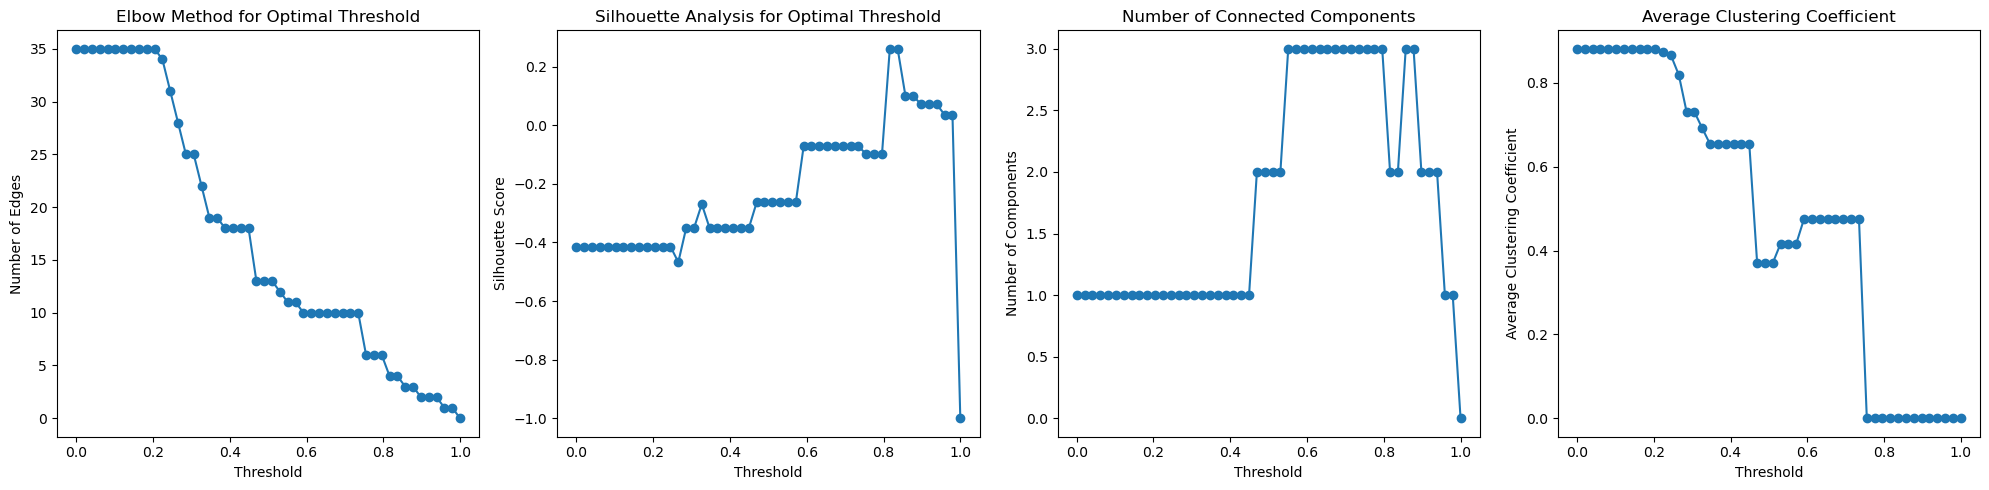

Added node: intrusion-set--1_blue with name: APT Intrusion Set (blue)
Added node: campaign--2_blue with name: APT Campaign (blue)
Added node: attack-pattern--3_blue with name: APT Attack Pattern (blue)
Added node: identity--6_blue with name: Franistan (blue)
Added node: identity--7_blue with name: Branistan People's Party (blue)
Added node: intrusion-set--1_red with name: Franistan-backed APT (red)
Added node: attack-pattern--2_red with name: Infuse False Data (red)
Added node: attack-pattern--3_red with name: DDoS Attack (red)
Added edge: intrusion-set--1_blue -> campaign--2_blue
Added edge: intrusion-set--1_blue -> attack-pattern--3_blue
Added edge: intrusion-set--1_blue -> identity--6_blue
Added edge: intrusion-set--1_blue -> identity--7_blue
Added edge: intrusion-set--1_red -> attack-pattern--2_red
Added edge: intrusion-set--1_red -> attack-pattern--3_red


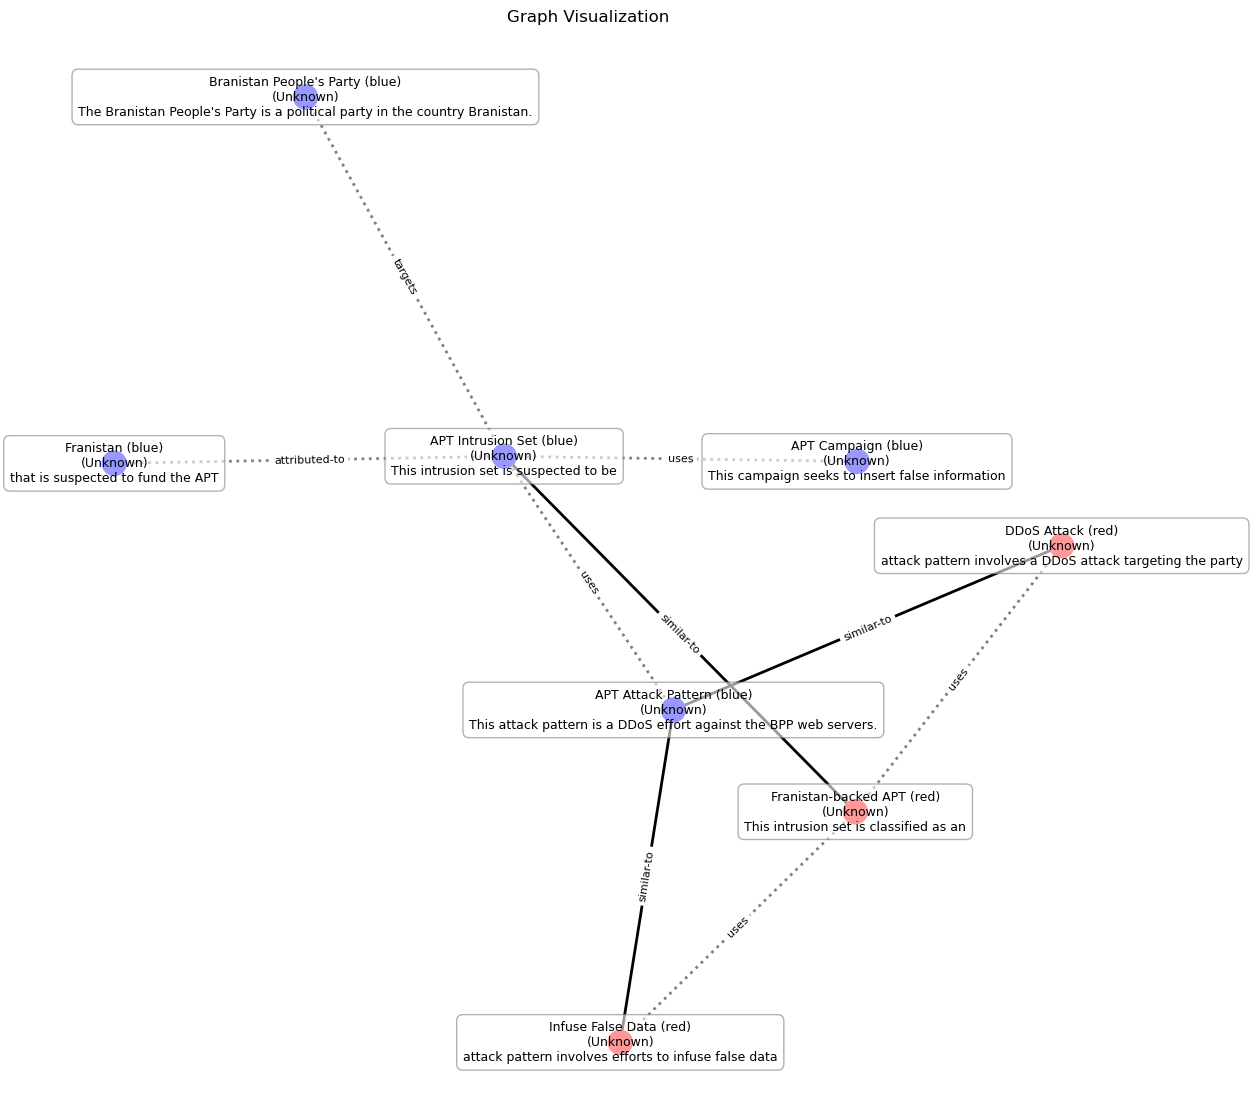

Unmatched Nodes:
campaign--2_blue: APT Campaign (blue)
identity--6_blue: Franistan (blue)
identity--7_blue: Branistan People's Party (blue)


In [5]:
import json
import networkx as nx
import matplotlib.pyplot as plt
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np

# Load the spaCy NLP model
nlp = spacy.load('en_core_web_sm')

# Ensure necessary resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')

def load_json(file_path):
    """Load JSON data from a file."""
    try:
        with open(file_path, 'r') as file:
            return json.load(file)
    except FileNotFoundError:
        print(f"Error: File not found - {file_path}")
        return None

def json_to_text(data):
    """Convert JSON entries to text for analysis."""
    texts = []
    ids = []
    json_objects = {}
    for entry in data:
        text = ". ".join(f"{key}: {value}" if not isinstance(value, list) else f"{key}: " + ", ".join(map(str, value)) for key, value in entry.items())
        texts.append(text)
        ids.append(entry['id'])
        json_objects[entry['id']] = entry
    return texts, ids, json_objects

def preprocess_json_objects(json_objects):
    """Ensure all JSON objects have required fields."""
    for obj in json_objects.values():
        obj.setdefault('name', 'Unknown Name')
        obj.setdefault('type', 'Unknown Type')
        obj.setdefault('description', 'No description provided')
    return json_objects

def extract_verb_centered_snippet(description, window=2, max_gap=4):
    """Extract snippets around the first two verbs found in the description."""
    doc = nlp(description)
    verbs = []
    for token in doc:
        if token.pos_ == 'VERB':
            verbs.append((token.i, token))
            if len(verbs) == 2:
                break

    if not verbs:
        return description

    if len(verbs) == 1:
        start = max(0, verbs[0][1].i - window)
        end = min(len(doc), verbs[0][1].i + window + 1)
        return doc[start:end].text

    v1, v2 = verbs
    if (v2[0] - v1[0]) <= max_gap:
        start = max(0, v1[1].i - window)
        end = min(len(doc), v2[1].i + window + 1)
        return doc[start:end].text
    else:
        snippet1 = doc[max(0, v1[1].i - window):v1[1].i + window + 1].text
        snippet2 = doc[max(0, v2[1].i - window):v2[1].i + window + 1].text
        return f"{snippet1} ... {snippet2}"

def build_graph(json_objects1, json_objects2, threshold):
    """Build a graph based on JSON objects."""
    G = nx.Graph()
    valid_nodes = set()

    # Add nodes from both JSON datasets, ensuring unique IDs
    for json_objects, dataset_suffix, dataset_color in [(json_objects1, '_blue', 'blue'), (json_objects2, '_red', 'red')]:
        for key, obj in json_objects.items():
            if obj['type'] != 'relationship':  # Only add entities as nodes
                if obj.get('name') != 'Unknown Name':  # Avoid adding unknown name nodes
                    unique_id = key + dataset_suffix
                    node_name = f"{obj.get('name', 'Unknown Entity')} ({dataset_color})"
                    G.add_node(unique_id, label=node_name, color=dataset_color,
                               description=obj.get('description', 'No description provided'))
                    valid_nodes.add(unique_id)
                    print(f"Added node: {unique_id} with name: {node_name}")
                else:
                    print(f"Filtered out node with id: {key} due to 'Unknown Name'")

    # Add edges from both JSON datasets, using unique IDs
    unique_edges = set()
    for json_objects, dataset_suffix, dataset_color in [(json_objects1, '_blue', 'gray'), (json_objects2, '_red', 'gray')]:
        for obj in json_objects.values():
            if obj['type'] == 'relationship':
                source = obj['source_ref'] + dataset_suffix
                target = obj['target_ref'] + dataset_suffix
                edge = (source, target)
                if source in valid_nodes and target in valid_nodes and source != target:  # Ensure both nodes are valid and not the same
                    if edge in unique_edges:
                        G[source][target]['style'] = 'solid'
                        G[source][target]['color'] = 'black'
                    else:
                        G.add_edge(source, target, style='dotted', color=dataset_color, label=obj.get('relationship_type', 'similar-to'))
                        unique_edges.add(edge)
                    print(f"Added edge: {source} -> {target}")
                else:
                    print(f"Filtered out edge from {source} to {target} due to invalid nodes")

    return G

def get_optimal_figsize(num_nodes):
    """Determine an optimal figure size based on the number of nodes."""
    base_size = 10  # Base size for the figure
    scale_factor = 0.5  # Scale factor to adjust size
    return (base_size + num_nodes * scale_factor, base_size + num_nodes * scale_factor)

def get_optimal_k(num_nodes):
    """Determine an optimal k value for spring_layout based on the number of nodes."""
    base_k = 0.5  # Base k value
    scale_factor = 0.1  # Scale factor to adjust k
    return base_k + num_nodes * scale_factor

def visualize_similarity_graph(G, unmatched_nodes):
    """Visualize a networkx graph with enhanced label formatting for readability."""
    num_nodes = len(G.nodes)
    figsize = get_optimal_figsize(num_nodes)
    k = get_optimal_k(num_nodes)

    plt.figure(figsize=figsize)  # Dynamically set figure size
    pos = nx.spring_layout(G, k=k)  # Dynamically set layout parameter

    # Draw nodes with their corresponding colors
    node_colors = [data.get('color', 'red' if node in unmatched_nodes else 'grey') for node, data in G.nodes(data=True)]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=300)

    # Draw edges with specified styles and colors
    for (u, v, data) in G.edges(data=True):
        nx.draw_networkx_edges(
            G, pos, edgelist=[(u, v)],
            style=data.get('style', 'dotted' if data['color'] == 'gray' else 'solid'),
            edge_color=data.get('color', 'black'),
            width=2
        )

    # Draw edge labels
    edge_labels = {(u, v): data.get('label', 'similar-to') for u, v, data in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    # Draw labels for nodes
    labels = {}
    for node, data in G.nodes(data=True):
        label = f"{data.get('label', 'Unknown')}\n({data.get('type', 'Unknown')})"
        description = data.get('description', 'No description provided')
        if description:
            snippet = extract_verb_centered_snippet(description)
            label += f"\n{snippet}"
        labels[node] = label

    for node, label in labels.items():
        x, y = pos[node]
        plt.text(x, y, label, fontsize=9, ha='center', va='center',
                 bbox=dict(boxstyle="round,pad=0.5", facecolor='white', edgecolor='gray', alpha=0.6))

    plt.title('Graph Visualization')
    plt.axis('off')
    plt.show()

    # Print unmatched nodes
    print("Unmatched Nodes:")
    for node in unmatched_nodes:
        print(f"{node}: {G.nodes[node]['label']}")

def plot_threshold_analysis(similarity_matrix):
    thresholds = np.linspace(0, 1, 50)
    num_edges = []
    silhouette_scores = []
    num_components = []
    avg_clustering = []

    for threshold in thresholds:
        G = nx.Graph()
        labels = np.zeros(similarity_matrix.shape[0])
        label_idx = 1
        for i, row in enumerate(similarity_matrix):
            for j, similarity in enumerate(row):
                if similarity > threshold:
                    G.add_edge(i, j)
                    if labels[i] == 0:
                        labels[i] = label_idx
                        label_idx += 1
                    labels[j] = labels[i]
        num_edges.append(len(G.edges))
        num_components.append(nx.number_connected_components(G))
        if len(G) > 0:
            avg_clustering.append(nx.average_clustering(G))
        else:
            avg_clustering.append(0)
        if len(set(labels)) > 1:
            silhouette_scores.append(silhouette_score(similarity_matrix, labels))
        else:
            silhouette_scores.append(-1)

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 4, 1)
    plt.plot(thresholds, num_edges, marker='o')
    plt.xlabel('Threshold')
    plt.ylabel('Number of Edges')
    plt.title('Elbow Method for Optimal Threshold')

    plt.subplot(1, 4, 2)
    plt.plot(thresholds, silhouette_scores, marker='o')
    plt.xlabel('Threshold')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Analysis for Optimal Threshold')

    plt.subplot(1, 4, 3)
    plt.plot(thresholds, num_components, marker='o')
    plt.xlabel('Threshold')
    plt.ylabel('Number of Components')
    plt.title('Number of Connected Components')

    plt.subplot(1, 4, 4)
    plt.plot(thresholds, avg_clustering, marker='o')
    plt.xlabel('Threshold')
    plt.ylabel('Average Clustering Coefficient')
    plt.title('Average Clustering Coefficient')

    plt.tight_layout()
    plt.show()

def main():
    path1 = input("Enter the file path for JSON 1: ").strip('"')
    path2 = input("Enter the file path for JSON 2: ").strip('"')

    data1 = load_json(path1)
    if data1 is None:
        return

    data2 = load_json(path2)
    if data2 is None:
        return

    texts1, ids1, json_objects1 = json_to_text(data1)
    texts2, ids2, json_objects2 = json_to_text(data2)

    json_objects1 = preprocess_json_objects(json_objects1)
    json_objects2 = preprocess_json_objects(json_objects2)

    vectorizer = TfidfVectorizer(tokenizer=word_tokenize, stop_words=stopwords.words('english'))
    tfidf1 = vectorizer.fit_transform(texts1)
    tfidf2 = vectorizer.transform(texts2)

    similarity_matrix = cosine_similarity(tfidf1, tfidf2)

    # Plot threshold analysis to determine the optimal threshold
    plot_threshold_analysis(similarity_matrix)

    # Choose a threshold value based on the analysis plots
    threshold = float(input("Enter the chosen threshold value: "))

    G = build_graph(json_objects1, json_objects2, threshold)
    unmatched_nodes = []

    for i, row in enumerate(similarity_matrix):
        for j, similarity in enumerate(row):
            if similarity > threshold:
                node1_id = ids1[i] + "_blue"
                node2_id = ids2[j] + "_red"
                if node1_id not in G.nodes and json_objects1[ids1[i]]['name'] != 'Unknown Name':
                    G.add_node(node1_id, label=json_objects1[ids1[i]]['name'], type=json_objects1[ids1[i]]['type'], description=json_objects1[ids1[i]]['description'])
                if node2_id not in G.nodes and json_objects2[ids2[j]]['name'] != 'Unknown Name':
                    G.add_node(node2_id, label=json_objects2[ids2[j]]['name'], type=json_objects2[ids2[j]]['type'], description=json_objects2[ids2[j]]['description'])
                G.add_edge(node1_id, node2_id, weight=similarity, style='solid', color='black', label='similar-to')

    for id1 in ids1:
        if not any(similarity_matrix[ids1.index(id1)][j] > threshold for j in range(len(ids2))):
            unmatched_nodes.append(id1 + "_blue")
            if id1 + "_blue" not in G.nodes and json_objects1[id1]['name'] != 'Unknown Name':
                G.add_node(id1 + "_blue", label=json_objects1[id1]['name'], type=json_objects1[id1]['type'], description=json_objects1[id1]['description'])

    for id2 in ids2:
        if not any(similarity_matrix[i][ids2.index(id2)] > threshold for i in range(len(ids1))):
            unmatched_nodes.append(id2 + "_red")
            if id2 + "_red" not in G.nodes and json_objects2[id2]['name'] != 'Unknown Name':
                G.add_node(id2 + "_red", label=json_objects2[id2]['name'], type=json_objects2[id2]['type'], description=json_objects2[id2]['description'])

    relationship_nodes = [node for node in G.nodes if 'relationship' in node]
    G.remove_nodes_from(relationship_nodes)

    visualize_similarity_graph(G, unmatched_nodes)

if __name__ == "__main__":
    main()
